In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [2]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 1 

max_x = 3
n_train = 1 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_SHM_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[1.50455306]
[-0.10905831]


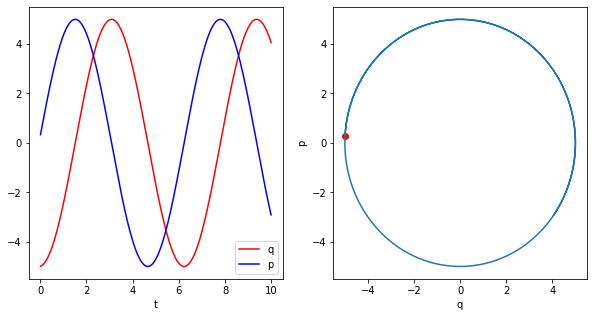

In [40]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(np.linspace(0.01, 10-0.01, data[0].shape[0]),data[0][:,0], label="q",color="red")
ax1.plot(np.linspace(0.01, 10-0.01, data[0].shape[0]),data[0][:,1], label="p",color="blue")
ax1.set_xlabel("t")
ax1.legend()
ax2.plot(data[0][:,0],data[0][:,1])
ax2.scatter(train_starting_position, train_starting_velocity,color="red")
ax2.set_xlabel("q")
ax2.set_ylabel("p")
plt.savefig("figures/SHM_trajectory_1D.pdf")

In [5]:

lml_moi = []
lml_inv = []
eva_future_moi = []
eva_future_inv = []
eva_grid_moi = []
eva_grid_inv = []
for i in range(5):
    test_starting_position = np.random.uniform(-max_x, max_x)
    test_starting_velocity = np.random.uniform(-max_x/5, max_x/5)

    print(test_starting_position)
    print(test_starting_velocity)

    test_data = get_SHM_data(time_step, testing_time, 1e-8, [test_starting_position], [test_starting_velocity])
    for jitter in [5e-6]:
    #    print("current jitter %s" %jitter)
        moi = get_GPR_model(get_MOI(), mean, data, 500)
        print("%s, "%round(moi.log_marginal_likelihood().numpy()))
        evaluate_moi = evaluate_model_future(moi, test_data, time_step)
        print(format(evaluate_moi[0],".4f"))

        lml_moi.append(moi.log_marginal_likelihood().numpy())
        eva_future_moi.append(evaluate_moi[0])
        eva_grid_moi.append(evaluate_model_grid(moi, 5, 40, SHM_dynamics))
        for invar_density in [40]: #np.arange(10, 30, 10):
                try:
                    kernel = get_SHM_invariance(5, invar_density, jitter) #switch
                    m = get_GPR_model(kernel, mean, data, 500)
                    print(round(m.log_marginal_likelihood().numpy()))
                    evaluate_invariance = evaluate_model_future(m, test_data, time_step)
                    print(format(evaluate_invariance[0],".4f"))
                    lml_inv.append(m.log_marginal_likelihood().numpy())
                    eva_future_inv.append(evaluate_invariance[0])
                    eva_grid_inv.append(evaluate_model_grid(m, 5, 40, SHM_dynamics))

                except tf.errors.InvalidArgumentError:
                    print("jitter too small")
                    break 

    # %%

-0.05697595233888375
-0.23300459919206934
69, 
0.0802
83
0.0000
2.713255166196653
-0.5054341905682768
69, 
0.1777
83
0.0269
1.304037218875437
-0.02199007653711027
69, 
0.0105
83
0.0031
1.0333705460235265
-0.3657044335540453
69, 
0.0224
83
0.0019
1.5267839099823606
-0.16889679790052475
69, 
0.0088
83
0.0025


In [6]:

print(format(np.mean(lml_moi),".4f"))
print(format(np.mean(lml_inv),".4f"))
print(format(np.mean(eva_future_moi),".4f"))
print(format(np.mean(eva_future_inv),".4f"))
print(format(np.mean(eva_grid_moi),".4f"))
print(format(np.mean(eva_grid_inv),".4f"))

68.7415
82.7903
0.0599
0.0069
7.7177
5.1843


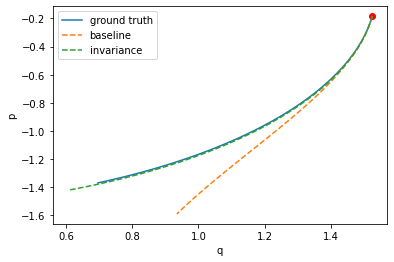

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(test_data[0][:,0],test_data[0][:,1], label="ground truth")
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='baseline')
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="invariance")
plt.scatter(test_data[0][0,0],test_data[0][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/SHM_predicted_trajectory.pdf")

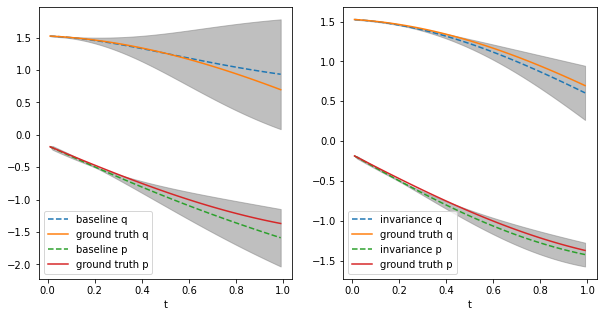

In [15]:

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
ax1.plot(t,evaluate_moi[1][:,0],'--',label="baseline q")
ax1.plot(t, test_data[0][:,0], label="ground truth q")
ax1.fill_between(t,evaluate_moi[1][:,0]+1.96*np.sqrt(evaluate_moi[2][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[1][:,0]-1.96*np.sqrt(evaluate_moi[2][:,0]+moi.likelihood.variance.numpy()), color="grey", alpha=0.5)
ax1.plot(t,evaluate_moi[1][:,1],'--',label="baseline p")
ax1.plot(t, test_data[0][:,1], label="ground truth p" )
ax1.fill_between(t,evaluate_moi[1][:,1]+1.96*np.sqrt(evaluate_moi[2][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[1][:,1]-1.96*np.sqrt(evaluate_moi[2][:,1]+moi.likelihood.variance.numpy()), color="grey", alpha=0.5)
ax1.set_xlabel("t")
ax1.legend()
ax2.plot(t,evaluate_invariance[1][:,0], '--', label="invariance q")
ax2.fill_between(t,evaluate_invariance[1][:,0]+1.96*np.sqrt(evaluate_invariance[2][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[1][:,0]-1.96*np.sqrt(evaluate_invariance[2][:,0]+m.likelihood.variance.numpy()), color="grey", alpha=0.5)
ax2.plot(t, test_data[0][:,0],label="ground truth q")
ax2.plot(t,evaluate_invariance[1][:,1], '--', label="invariance p")
ax2.plot(t, test_data[0][:,1],label="ground truth p")
ax2.fill_between(t,evaluate_invariance[1][:,1]+1.96*np.sqrt(evaluate_invariance[2][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[1][:,1]-1.96*np.sqrt(evaluate_invariance[2][:,1]+m.likelihood.variance.numpy()), color="grey", alpha=0.5)
ax2.set_xlabel("t")
ax2.legend()
plt.savefig("figures/SHM_predicted_trajectory_seperate.pdf")